In [ ]:
!pip install shap
import pandas as pd
from patsy import dmatrix
import numpy as np
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from joblib import Parallel, delayed
import multiprocessing
import shap
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn import svm
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from scipy.stats import zscore

# Stock_month final data already saved, so directly load
stock_month = pd.read_pickle('/content/drive/My Drive/SWIB Quant Intern/stock_month_6_30.pkl')

1. Risk Premium. 

    1.1 Z-score

    1.2 Rank

2. Excess return
    
    1.1 Z-score
    
    1.2 Rank


# Predict Excess Return

In this section, We are to predict next month excess return. 
Signals should be in the same space as Y.
Suppose month T is the current month.

stock_i_Month_T_return = (month_T.d_return+1).cumprod().iloc[-1] -1 

stock_i_month_T_excess_return = stock_i_month_T_return - spxt_month_T_return.

stock_i_mom6m =  ((T-5:T-1).d_return+1).cumprod().iloc[-1] -1

stock_i_excess_return_mom = stock_i_momentum - spxt_momentum 

  Y: next month _excess_return (T+1). 

  excess_return_Mom1m:  (T)

  excess_return_Mom6m: previous T-5:T-1

  excess_return_Mom12m: previous T-11:T-1 

  excess_return_mom36m: T-35:T-12 

  excess_return_maxret1 : max monthly excess_return in the last 12 month (T-12:T)

  excess_return_maxret2 : max daily excess_return in the last 1 month (T)

  turnover: dollar volume / market cap

  beta: risk_premium = beta * market_premium. Set threshold ==100 if latest available dates are smaller than 100, beta is nan.

  beta^2

  retvol: stdev(daily risk premium)*sqrt(252). 

  idiovol: stdev(daily regression residual)*sqrt(252)


In [ ]:
# How to handle missing data? 
# I remove all rows contains NA
stock_month_excess_return = stock_month.loc[:,['year_month','sedol','sector','excess_return','next_month_excess_return','excess_mom6m','excess_mom12m',
                  'excess_mom36m','maxret1_excess','maxret2_excess','turnover','mktcap','beta','beta_sq','retvol','idiovol','Month_T']].dropna()
stock_month_excess_return # 79604

### Z-score

How to standardize features? In this section

1. Cross sectionally calculate Z-score
2. Cross sectionally and by sector calculate Z-score

In [ ]:
# 1. 
# save columns that don't need to get z-score
stock_month_excess_return_z1 = stock_month_excess_return.loc[:,['year_month','sedol','Month_T','sector']]
# get z-score and combine
stock_month_excess_return_z1 = pd.concat( [ stock_month_excess_return_z1, stock_month_excess_return.loc[:,
                                          ['excess_return', 'excess_mom6m', 'excess_mom12m',
                                            'excess_mom36m','maxret1_excess','maxret2_excess',
                                            'turnover','mktcap','beta','beta_sq','retvol','idiovol','Month_T','next_month_excess_return'] 
                                              ].groupby(['Month_T']).transform(lambda df: (df - df.mean())/df.std() ) ],
                                                                               axis=1 )
stock_month_excess_return_z1

In [184]:
# 2. 
# save columns that don't need to get z-score
stock_month_excess_return_z2 = stock_month_excess_return.loc[:,['year_month','sedol','Month_T','sector']]
# get z-score and combine
stock_month_excess_return_z2 = pd.concat( [ stock_month_excess_return_z2, stock_month_excess_return.loc[:,
                                          ['sector','excess_return', 'excess_mom6m', 'excess_mom12m',
                                            'excess_mom36m','maxret1_excess','maxret2_excess',
                                            'turnover','mktcap','beta','beta_sq','retvol','idiovol','Month_T','next_month_excess_return'] 
                                              ].groupby(['Month_T','sector']).transform(lambda df: (df - df.mean())/df.std() ) ],
                                                                               axis=1 )
stock_month_excess_return_z2 = stock_month_excess_return_z2.dropna()

,year_month,sedol,Month_T,sector,excess_return,excess_mom6m,excess_mom12m,excess_mom36m,maxret1_excess,maxret2_excess,turnover,mktcap,beta,beta_sq,retvol,idiovol,next_month_excess_return
55,2004-08,2002305,35,Health Care,1.008501,0.404193,-0.121542,-0.437686,-0.391869,-0.260552,-0.648830,0.669178,0.549220,0.400154,-0.839902,-0.819304,0.054319
56,2004-09,2002305,36,Health Care,0.054319,0.975678,-0.065156,-0.449759,-0.398219,-0.816271,-0.664196,0.731868,1.124485,1.163773,-0.949539,-0.964548,0.499381
57,2004-10,2002305,37,Health Care,0.492580,0.518795,0.042590,-0.541731,-0.392977,-0.589212,-0.613119,0.808796,1.297017,1.383867,-1.084713,-1.099952,-0.680092
58,2004-11,2002305,38,Health Care,-0.686407,0.630390,0.162812,-0.516196,-0.416664,-0.487415,-0.559557,0.883247,1.475492,1.702631,-1.056485,-1.087918,0.807488
59,2004-12,2002305,39,Health Care,0.807488,0.326679,-0.125068,-0.498640,-0.315450,0.728264,-0.566233,0.915796,1.625230,1.945613,-1.201610,-1.223451,-0.082233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2020-05,BD0Q558,224,Industrials,-0.393575,0.705524,1.053947,0.114397,-0.611206,-1.291893,-0.369544,-0.134701,-0.020009,-0.153496,-0.198370,-0.174265,-0.510793
244,2020-05,2045623,224,Information Technology,0.276696,0.437188,0.948530,0.422930,-0.149098,-0.518373,-0.538274,-0.344962,0.439483,0.377016,-0.268430,-0.430208,-0.614469
244,2020-05,2556868,224,Financials,1.609205,-0.663144,-0.708764,-0.483386,0.628783,-0.463024,0.776323,-0.497089,0.353314,0.236839,-0.703383,-0.606812,-0.081431
244,2020-05,2679204,224,Health Care,1.646879,-1.585369,-1.741859,2.292712,2.973423,3.379881,2.492853,-0.638562,-1.323039,-1.181026,2.364412,2.333747,3.182501


Build models:
1. LASSO(baseline)
2. Random Forest

In [197]:
# split data, remember after remove NAs, T starts from 35 to 225. 
# training 36: 180,   testing 180:225
features = ['Month_T', 'excess_return', 'excess_mom6m', 'excess_mom12m', 'excess_mom36m','maxret1_excess', 'maxret2_excess', 
            'turnover','mktcap','beta','retvol','idiovol']
           

X_train1 = stock_month_excess_return_z1.loc[ stock_month_excess_return_z1.Month_T.isin(np.arange(0,180)) , features] ## total ,    in training
Y_train1 = stock_month_excess_return_z1.loc[ stock_month_excess_return_z1.Month_T.isin(np.arange(0,180)) , 'next_month_excess_return']

X_test1 = stock_month_excess_return_z1.loc[ stock_month_excess_return_z1.Month_T.isin(np.arange(180,226)) , features] # 
Y_test1 = stock_month_excess_return_z1.loc[ stock_month_excess_return_z1.Month_T.isin(np.arange(180,226)) , 'next_month_excess_return'] #  in test


X_train2 = stock_month_excess_return_z2.loc[ stock_month_excess_return_z2.Month_T.isin(np.arange(0,180)) , features] ## total ,    in training
Y_train2 = stock_month_excess_return_z2.loc[ stock_month_excess_return_z2.Month_T.isin(np.arange(0,180)) , 'next_month_excess_return']

X_test2 = stock_month_excess_return_z2.loc[ stock_month_excess_return_z2.Month_T.isin(np.arange(180,226)) , features] # 
Y_test2 = stock_month_excess_return_z2.loc[ stock_month_excess_return_z2.Month_T.isin(np.arange(180,226)) , 'next_month_excess_return'] #  in test


#### LASSO

-0.0012627511395915114
[-0.          0.         -0.          0.00801171 -0.         -0.
 -0.00674088  0.03657712 -0.01188638 -0.00487085 -0.         -0.02179491]


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!


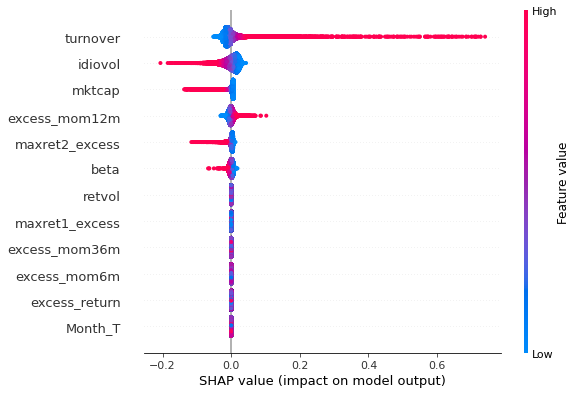

In [198]:
# 1 cross section z-score
las = LassoCV(cv=5, random_state=2).fit(X_train1, Y_train1)
print(las.score(X_test1,Y_test1))
print(las.coef_)

# 1 cross section z-score, Shap for lasso 
explainer = shap.LinearExplainer(las, X_train1, feature_dependence="independent")
shap_values = explainer.shap_values(X_train1)
shap.summary_plot(shap_values, X_train1)

-0.0006613324653665931
[ 0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.17493719e-02
  6.33877744e-05 -1.11434477e-03 -8.24644820e-03  3.08287366e-02
 -8.67947321e-03  0.00000000e+00 -0.00000000e+00 -4.63599932e-03]


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!


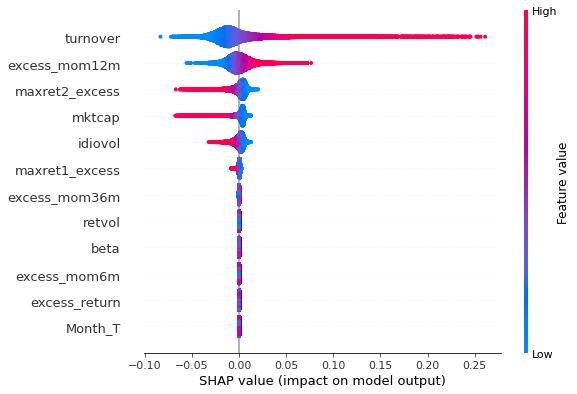

In [199]:
# 2 cross section and by sector z-score
las = LassoCV(cv=5, random_state=2).fit(X_train2, Y_train2)
print(las.score(X_test2,Y_test2))
print(las.coef_)

# 2 cross section and by sector z-score, Shap for lasso 
explainer = shap.LinearExplainer(las, X_train2, feature_dependence="independent")
shap_values = explainer.shap_values(X_train2)
shap.summary_plot(shap_values, X_train2)

#### random forest

-0.0002604774700036838


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


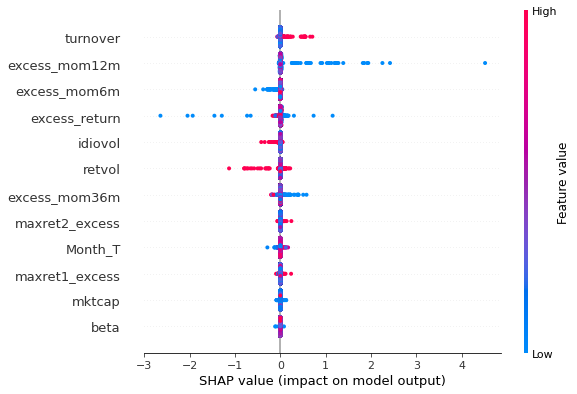

In [200]:
# 1 cross sectionally
rf = RandomForestRegressor(max_depth=3,random_state=0).fit(X_train1, Y_train1)
print(rf.score(X_test1,Y_test1)) 

# Shap for random forest
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train1)
shap.summary_plot(shap_values, X_train1)

-0.00028739520055598433


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


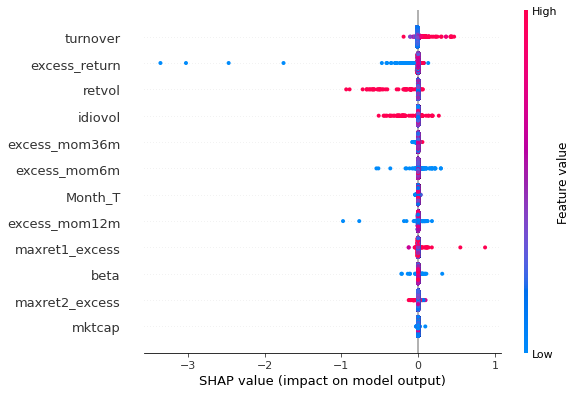

In [201]:
# 2 cross sectionally + sector
rf = RandomForestRegressor(max_depth=3,random_state=0).fit(X_train2, Y_train2)
print(rf.score(X_test2,Y_test2)) 

# Shap for random forest
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train2)
shap.summary_plot(shap_values, X_train2)

### Rank
How to standardize features? 
In this section 
1. Cross sectionally rank features and Y. 
2. Cross sectionally and by sector rank features and Y.

Note that rank excess_return is essentially the rank of return.


In [ ]:
# 1 Just cross sectionaly rank
# save unranked columns
stock_month_excess_return_r1 = stock_month_excess_return.loc[:,['year_month','sedol','Month_T','sector']]

# combine the ranked columns with previous df
stock_month_excess_return_r1 = pd.concat( [stock_month_excess_return_r1, 
                            stock_month_excess_return.loc[:,['excess_return', 'excess_mom6m', 'excess_mom12m',
                                            'excess_mom36m','maxret1_excess','maxret2_excess',
                                            'turnover','mktcap','beta','beta_sq','retvol','idiovol','Month_T','next_month_excess_return'] ].groupby(['Month_T']).rank(pct = True)],axis=1 )
stock_month_excess_return_r1

In [204]:
# 2 
# save unranked columns
stock_month_excess_return_r2 = stock_month_excess_return.loc[:,['year_month','sedol','Month_T','sector']]

# combine the ranked columns with previous df
stock_month_excess_return_r2 = pd.concat( [stock_month_excess_return_r2, 
                            stock_month_excess_return.loc[:,['sector','excess_return', 'excess_mom6m', 'excess_mom12m',
                                            'excess_mom36m','maxret1_excess','maxret2_excess',
                                            'turnover','mktcap','beta','beta_sq','retvol','idiovol','Month_T','next_month_excess_return'] ].groupby(['Month_T','sector']).rank(pct = True)],axis=1 )
stock_month_excess_return_r2

,year_month,sedol,Month_T,sector,excess_return,excess_mom6m,excess_mom12m,excess_mom36m,maxret1_excess,maxret2_excess,turnover,mktcap,beta,beta_sq,retvol,idiovol,next_month_excess_return
55,2004-08,2002305,35,Health Care,0.850000,0.650000,0.475000,0.350000,0.425000,0.500000,0.075000,0.875000,0.750000,0.750000,0.150000,0.200000,0.500000
56,2004-09,2002305,36,Health Care,0.500000,0.850000,0.525000,0.400000,0.400000,0.150000,0.075000,0.875000,0.875000,0.875000,0.125000,0.125000,0.775000
57,2004-10,2002305,37,Health Care,0.780488,0.756098,0.560976,0.341463,0.414634,0.268293,0.073171,0.902439,0.902439,0.902439,0.121951,0.097561,0.219512
58,2004-11,2002305,38,Health Care,0.219512,0.682927,0.560976,0.365854,0.414634,0.390244,0.073171,0.926829,0.902439,0.902439,0.073171,0.097561,0.804878
59,2004-12,2002305,39,Health Care,0.804878,0.634146,0.463415,0.317073,0.463415,0.804878,0.048780,0.926829,0.975610,0.975610,0.097561,0.073171,0.463415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2020-05,BD0Q558,224,Industrials,0.333333,0.825397,0.888889,0.571429,0.285714,0.015873,0.047619,0.650794,0.428571,0.428571,0.539683,0.587302,0.301587
244,2020-05,2045623,224,Information Technology,0.625000,0.714286,0.821429,0.678571,0.642857,0.321429,0.375000,0.392857,0.642857,0.642857,0.500000,0.392857,0.285714
244,2020-05,2556868,224,Financials,0.950000,0.283333,0.216667,0.316667,0.733333,0.333333,0.816667,0.133333,0.683333,0.683333,0.283333,0.366667,0.433333
244,2020-05,2679204,224,Health Care,0.956522,0.065217,0.021739,1.000000,0.978261,1.000000,0.978261,0.304348,0.130435,0.130435,0.978261,0.978261,1.000000


Build models:
1. LASSO(baseline)
2. Random Forest

In [206]:
# split data, remember after remove NAs, T starts from 35 to 225. 
# training 36: 180,   testing 180:225
features = ['Month_T', 'excess_return', 'excess_mom6m', 'excess_mom12m', 'excess_mom36m','maxret1_excess', 'maxret2_excess', 
            'turnover','mktcap','beta','retvol','idiovol']
           

X_train1 = stock_month_excess_return_r1.loc[ stock_month_excess_return_r1.Month_T.isin(np.arange(0,180)) , features] ## total 79604,   61191 in training
Y_train1 = stock_month_excess_return_r1.loc[ stock_month_excess_return_r1.Month_T.isin(np.arange(0,180)) , 'next_month_excess_return']

X_test1 = stock_month_excess_return_r1.loc[ stock_month_excess_return_r1.Month_T.isin(np.arange(180,226)) , features] # 
Y_test1 = stock_month_excess_return_r1.loc[ stock_month_excess_return_r1.Month_T.isin(np.arange(180,226)) , 'next_month_excess_return'] # 18413 in test


X_train2 = stock_month_excess_return_r2.loc[ stock_month_excess_return_r2.Month_T.isin(np.arange(0,180)) , features] ## total 79604,   61191 in training
Y_train2 = stock_month_excess_return_r2.loc[ stock_month_excess_return_r2.Month_T.isin(np.arange(0,180)) , 'next_month_excess_return']

X_test2 = stock_month_excess_return_r2.loc[ stock_month_excess_return_r2.Month_T.isin(np.arange(180,226)) , features] # 
Y_test2 = stock_month_excess_return_r2.loc[ stock_month_excess_return_r2.Month_T.isin(np.arange(180,226)) , 'next_month_excess_return'] # 18413 in test


#### LASSO

0.00018169910547050083
[ 2.10878271e-07 -4.04904018e-03 -1.60507751e-02  2.64991220e-02
  1.31780852e-02 -6.89990890e-03 -1.69103543e-02  3.83787857e-02
 -8.71484353e-03 -2.64121331e-02  5.23021316e-02 -8.81073447e-02]


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!


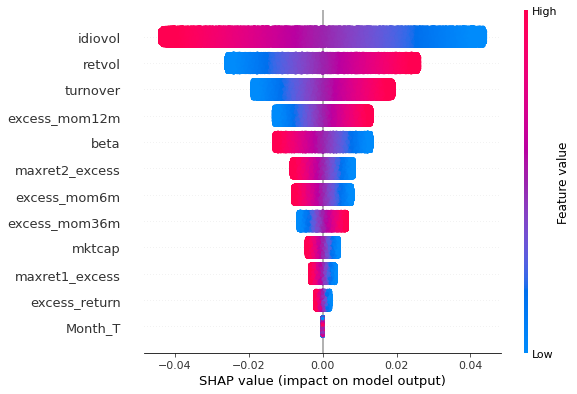

In [207]:
# 1 cross section rank
las = LassoCV(cv=5, random_state=2).fit(X_train1, Y_train1)
print(las.score(X_test1,Y_test1))
print(las.coef_)

# 1 cross section rank, Shap for lasso 
explainer = shap.LinearExplainer(las, X_train1, feature_dependence="independent")
shap_values = explainer.shap_values(X_train1)
shap.summary_plot(shap_values, X_train1)

-0.00023118102633934434
[ 4.54625105e-06 -3.73396282e-03 -0.00000000e+00  1.60747922e-02
  1.07565686e-02 -4.18486366e-04 -2.64176397e-03  3.57707670e-02
 -1.53641521e-04  1.37121109e-02  0.00000000e+00 -0.00000000e+00]


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!


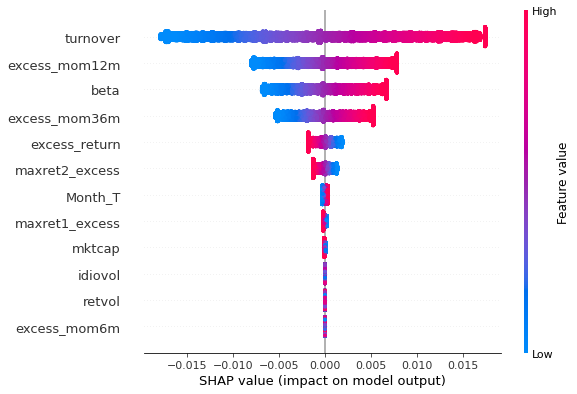

In [208]:
# 2 cross section and by sector rank
las = LassoCV(cv=5, random_state=2).fit(X_train2, Y_train2)
print(las.score(X_test2,Y_test2))
print(las.coef_)

# 2 cross section and by sector rank, Shap for lasso 
explainer = shap.LinearExplainer(las, X_train2, feature_dependence="independent")
shap_values = explainer.shap_values(X_train2)
shap.summary_plot(shap_values, X_train2)

#### Random Forest

-0.002376596768472128


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


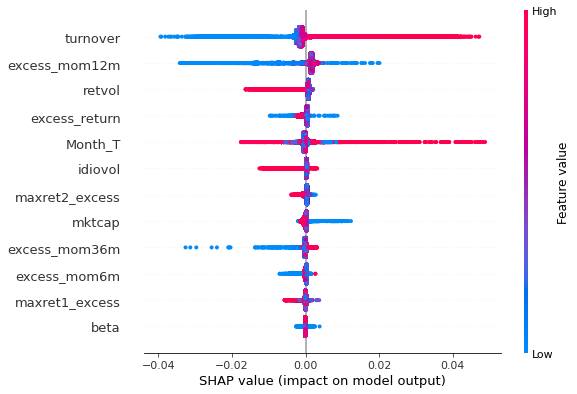

In [209]:
# 1 cross sectionally
rf = RandomForestRegressor(max_depth=3,random_state=0).fit(X_train1, Y_train1)
print(rf.score(X_test1,Y_test1)) 

# Shap for random forest
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train1)
shap.summary_plot(shap_values, X_train1)

-0.00016793717951912865


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


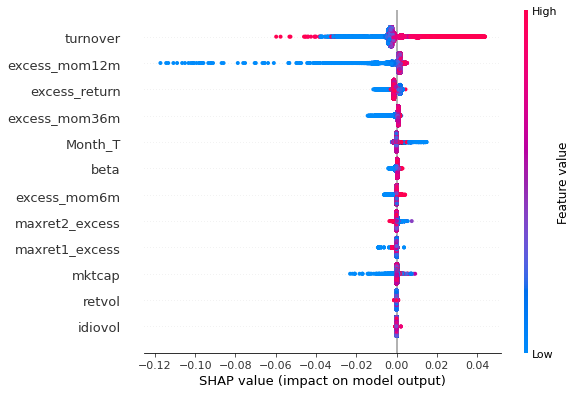

In [210]:
# 2 cross sectionally + sector
rf = RandomForestRegressor(max_depth=3,random_state=0).fit(X_train2, Y_train2)
print(rf.score(X_test2,Y_test2)) 

# Shap for random forest
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train2)
shap.summary_plot(shap_values, X_train2)

# Predict Risk Premium

In this section, We are to predict next month Risk premium. 
Signals should be in the same space as Y.
Suppose month T is the current month.

stock_i_Month_T_return = (month_T.d_return+1).cumprod().iloc[-1] -1 

stock_i_month_T_risk_premium = stock_i_month_T_return - libor_month_T_return.

stock_i_mom6m =  ((T-5:T-1).d_return+1).cumprod().iloc[-1] -1

stock_i_risk_premium_momentum = stock_i_momentum - libor_momentum 

  Y: next month risk_premium (T+1). 

  risk_premium_Mom1m:  (T)

  risk_premium_Mom6m: previous T-5:T-1

  risk_premium_Mom12m: previous T-11:T-1 

  risk_premium_mom36m: T-35:T-12 

  risk_premium_maxret1 : max monthly risk_premium in the last 12 month (T-12:T)

  risk_premium_maxret2 : max daily risk_premium in the last 1 month (T)

  turnover: dollar volume / market cap

  beta: risk_premium = beta * market_premium. Set threshold ==100 if latest available dates are smaller than 100, beta is nan.

  beta^2

  retvol: stdev(daily risk premium)*sqrt(252). 

  idiovol: stdev(daily regression residual)*sqrt(252)


In [ ]:
# How to handle missing data? 
# I remove all rows contains NA
stock_month_risk_premium = stock_month.loc[:,['year_month','sedol','sector','risk_premium','next_month_risk_premium','risk_premium_mom6m','risk_premium_mom12m',
                  'risk_premium_mom36m','maxret1_risk_premium','maxret2_risk_premium','turnover','mktcap','beta','beta_sq','retvol','idiovol','Month_T']].dropna()
stock_month_risk_premium # 79604

### Z-score

How to standardize features? In this section

1. Cross sectionally calculate Z-score
2. Cross sectionally and by sector calculate Z-score

In [ ]:
# 1. 
# save columns that don't need to get z-score
stock_month_risk_premium_z1 = stock_month_risk_premium.loc[:,['year_month','sedol','Month_T','sector']]
# get z-score and combine
stock_month_risk_premium_z1 = pd.concat( [ stock_month_risk_premium_z1, stock_month_risk_premium.loc[:,
                                          ['risk_premium', 'risk_premium_mom6m', 'risk_premium_mom12m',
                                            'risk_premium_mom36m','maxret1_risk_premium','maxret2_risk_premium',
                                            'turnover','mktcap','beta','beta_sq','retvol','idiovol','Month_T','next_month_risk_premium'] 
                                              ].groupby(['Month_T']).transform(lambda df: (df - df.mean())/df.std() ) ],
                                                                               axis=1 )
stock_month_risk_premium_z1

In [ ]:
# 2. 
# save columns that don't need to get z-score
stock_month_risk_premium_z2 = stock_month_risk_premium.loc[:,['year_month','sedol','Month_T','sector']]
# get z-score and combine
stock_month_risk_premium_z2 = pd.concat( [ stock_month_risk_premium_z2, stock_month_risk_premium.loc[:,
                                          ['sector','risk_premium', 'risk_premium_mom6m', 'risk_premium_mom12m',
                                            'risk_premium_mom36m','maxret1_risk_premium','maxret2_risk_premium',
                                            'turnover','mktcap','beta','beta_sq','retvol','idiovol','Month_T','next_month_risk_premium'] 
                                              ].groupby(['Month_T','sector']).transform(lambda df: (df - df.mean())/df.std() ) ],
                                                                               axis=1 )
stock_month_risk_premium_z2 = stock_month_risk_premium_z2.dropna()

Build models:
1. LASSO(baseline)
2. Random Forest

In [175]:
# split data, remember after remove NAs, T starts from 35 to 225. 
# training 36: 180,   testing 180:225
features = ['Month_T', 'risk_premium', 'risk_premium_mom6m', 'risk_premium_mom12m', 'risk_premium_mom36m','maxret1_risk_premium', 'maxret2_risk_premium', 
            'turnover','mktcap','beta','retvol','idiovol']
           

X_train1 = stock_month_risk_premium_z1.loc[ stock_month_risk_premium_z1.Month_T.isin(np.arange(0,180)) , features] ## total 79604,   61191 in training
Y_train1 = stock_month_risk_premium_z1.loc[ stock_month_risk_premium_z1.Month_T.isin(np.arange(0,180)) , 'next_month_risk_premium']

X_test1 = stock_month_risk_premium_z1.loc[ stock_month_risk_premium_z1.Month_T.isin(np.arange(180,226)) , features] # 
Y_test1 = stock_month_risk_premium_z1.loc[ stock_month_risk_premium_z1.Month_T.isin(np.arange(180,226)) , 'next_month_risk_premium'] # 18413 in test


X_train2 = stock_month_risk_premium_z2.loc[ stock_month_risk_premium_z2.Month_T.isin(np.arange(0,180)) , features] ## total 79604,   61191 in training
Y_train2 = stock_month_risk_premium_z2.loc[ stock_month_risk_premium_z2.Month_T.isin(np.arange(0,180)) , 'next_month_risk_premium']

X_test2 = stock_month_risk_premium_z2.loc[ stock_month_risk_premium_z2.Month_T.isin(np.arange(180,226)) , features] # 
Y_test2 = stock_month_risk_premium_z2.loc[ stock_month_risk_premium_z2.Month_T.isin(np.arange(180,226)) , 'next_month_risk_premium'] # 18413 in test


#### LASSO

<s>My understanding is that shap value is just coef_...  </s>

-0.00137910300940991
[ 0.          0.         -0.          0.00785237 -0.          0.
 -0.00564424  0.03591705 -0.01169439 -0.00321857 -0.         -0.02046457]


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!


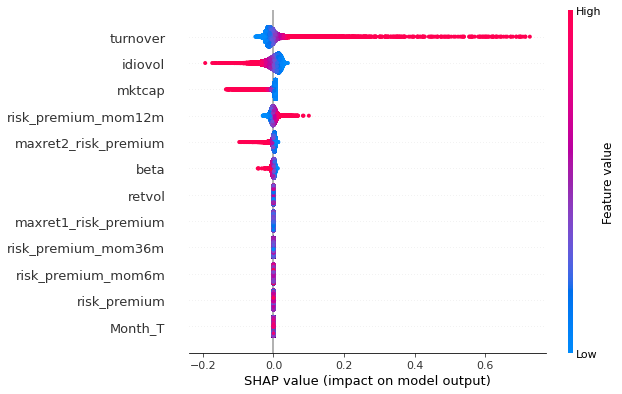

In [167]:
# 1 cross section z-score
las = LassoCV(cv=5, random_state=2).fit(X_train1, Y_train1)
print(las.score(X_test1,Y_test1))
print(las.coef_)

# 1 cross section z-score, Shap for lasso 
explainer = shap.LinearExplainer(las, X_train1, feature_dependence="independent")
shap_values = explainer.shap_values(X_train1)
shap.summary_plot(shap_values, X_train1)

-0.0007715090501279054
[ 0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.14561586e-02
  5.38456040e-05  0.00000000e+00 -4.68396316e-03  2.96578132e-02
 -8.45749158e-03  0.00000000e+00 -0.00000000e+00 -6.26013900e-03]


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!


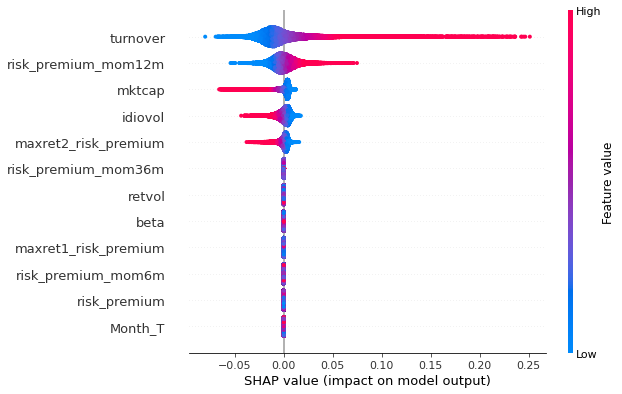

In [176]:
# 2 cross section and by sector z-score
las = LassoCV(cv=5, random_state=2).fit(X_train2, Y_train2)
print(las.score(X_test2,Y_test2))
print(las.coef_)

# 2 cross section and by sector z-score, Shap for lasso 
explainer = shap.LinearExplainer(las, X_train2, feature_dependence="independent")
shap_values = explainer.shap_values(X_train2)
shap.summary_plot(shap_values, X_train2)

#### Random Forest

-0.0002561848448872084


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


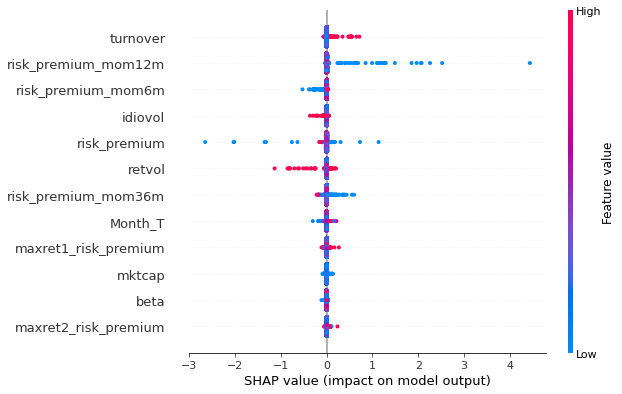

In [177]:
# 1 cross sectionally
rf = RandomForestRegressor(max_depth=3,random_state=0).fit(X_train1, Y_train1)
print(rf.score(X_test1,Y_test1)) 

# Shap for random forest
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train1)
shap.summary_plot(shap_values, X_train1)

-0.00035073729218293437


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


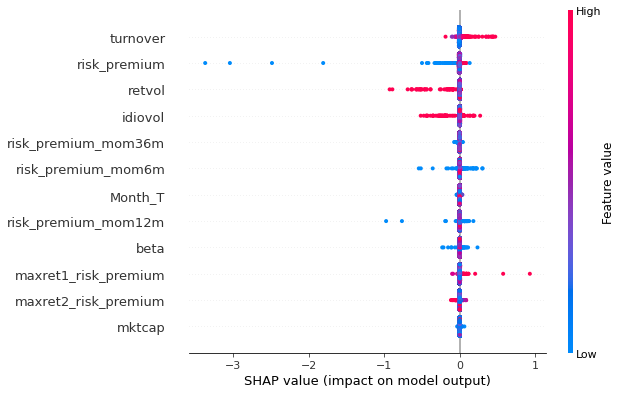

In [178]:
# 2 cross sectionally + sector
rf = RandomForestRegressor(max_depth=3,random_state=0).fit(X_train2, Y_train2)
print(rf.score(X_test2,Y_test2)) 

# Shap for random forest
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train2)
shap.summary_plot(shap_values, X_train2)

### Rank
How to standardize features?
In this section 
1. Cross sectionally rank features and Y. 
2. Cross sectionally and by sector rank features and Y.


In [ ]:
# 1 Just cross sectionaly rank
# save unranked columns
stock_month_risk_premium_r1 = stock_month_risk_premium.loc[:,['year_month','sedol','Month_T','sector']]

# combine the ranked columns with previous df
stock_month_risk_premium_r1 = pd.concat( [stock_month_risk_premium_r1, 
                            stock_month_risk_premium.loc[:,['risk_premium', 'risk_premium_mom6m', 'risk_premium_mom12m',
                                                            'risk_premium_mom36m','maxret1_risk_premium','maxret2_risk_premium',
                   'turnover','mktcap','beta','beta_sq','retvol','idiovol','Month_T','next_month_risk_premium'] ].groupby(['Month_T']).rank(pct = True)],axis=1 )
stock_month_risk_premium_r1

In [ ]:
# 2. Cross section + sector rank
# save unranked columns
stock_month_risk_premium_r2 = stock_month_risk_premium.loc[:,['year_month','sedol','Month_T','sector']]

# combine the ranked columns with previous df
stock_month_risk_premium_r2 = pd.concat( [stock_month_risk_premium_r2, 
                            stock_month_risk_premium.loc[:,['sector','risk_premium', 'risk_premium_mom6m', 'risk_premium_mom12m',
                                                            'risk_premium_mom36m','maxret1_risk_premium','maxret2_risk_premium',
                   'turnover','mktcap','beta','beta_sq','retvol','idiovol','Month_T','next_month_risk_premium'] ].groupby(['Month_T','sector']).rank(pct = True)],axis=1 )
stock_month_risk_premium_r2

Build models:
1. LASSO(baseline)
2. Random Forest

In [70]:
# split data, remember after remove NAs, T starts from 35 to 225. 
# training 36: 180,   testing 180:225
features = ['Month_T', 'risk_premium', 'risk_premium_mom6m', 'risk_premium_mom12m', 'risk_premium_mom36m','maxret1_risk_premium', 'maxret2_risk_premium', 
            'turnover','mktcap','beta','retvol','idiovol']
           

X_train1 = stock_month_risk_premium_r1.loc[ stock_month_risk_premium_r1.Month_T.isin(np.arange(0,180)) , features] ## total 79604,   61191 in training
Y_train1 = stock_month_risk_premium_r1.loc[ stock_month_risk_premium_r1.Month_T.isin(np.arange(0,180)) , 'next_month_risk_premium']

X_test1 = stock_month_risk_premium_r1.loc[ stock_month_risk_premium_r1.Month_T.isin(np.arange(180,226)) , features] # 
Y_test1 = stock_month_risk_premium_r1.loc[ stock_month_risk_premium_r1.Month_T.isin(np.arange(180,226)) , 'next_month_risk_premium'] # 18413 in test


X_train2 = stock_month_risk_premium_r2.loc[ stock_month_risk_premium_r2.Month_T.isin(np.arange(0,180)) , features] ## total 79604,   61191 in training
Y_train2 = stock_month_risk_premium_r2.loc[ stock_month_risk_premium_r2.Month_T.isin(np.arange(0,180)) , 'next_month_risk_premium']

X_test2 = stock_month_risk_premium_r2.loc[ stock_month_risk_premium_r2.Month_T.isin(np.arange(180,226)) , features] # 
Y_test2 = stock_month_risk_premium_r2.loc[ stock_month_risk_premium_r2.Month_T.isin(np.arange(180,226)) , 'next_month_risk_premium'] # 18413 in test


#### LASSO

My understanding is that shap value is just coef_...

-0.00015380560844913127
[ 2.09354251e-07 -7.37621262e-03 -1.64779290e-02  2.35723610e-02
  1.37289219e-02  5.33201706e-03 -1.17638782e-02  3.67946105e-02
 -8.82417822e-03 -2.23366714e-02  6.17780627e-02 -1.03751503e-01]


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!


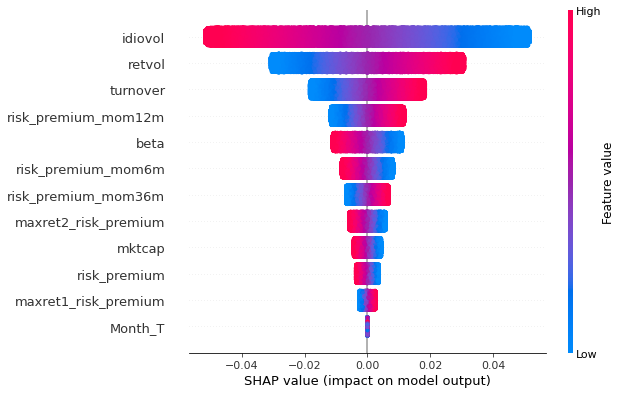

In [71]:
# 1 cross section rank
las = LassoCV(cv=5, random_state=2).fit(X_train1, Y_train1)
print(las.score(X_test1,Y_test1))
print(las.coef_)

# 1 cross section rank, Shap for lasso 
explainer = shap.LinearExplainer(las, X_train1, feature_dependence="independent")
shap_values = explainer.shap_values(X_train1)
shap.summary_plot(shap_values, X_train1)

-0.00023689523871461837
[ 4.51931247e-06 -4.07860588e-03 -0.00000000e+00  1.55947608e-02
  1.03940577e-02  0.00000000e+00 -0.00000000e+00  3.43931156e-02
 -0.00000000e+00  1.41429372e-02  0.00000000e+00 -0.00000000e+00]


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!


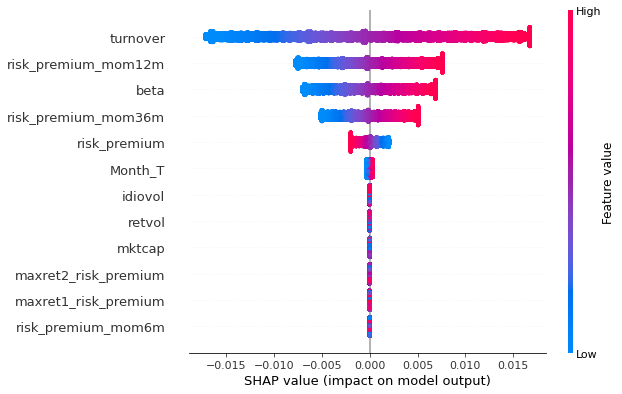

In [72]:
# 2 cross section and by sector rank
las = LassoCV(cv=5, random_state=2).fit(X_train2, Y_train2)
print(las.score(X_test2,Y_test2))
print(las.coef_)

# 2 cross section and by sector rank, Shap for lasso 
explainer = shap.LinearExplainer(las, X_train2, feature_dependence="independent")
shap_values = explainer.shap_values(X_train2)
shap.summary_plot(shap_values, X_train2)

#### Random Forest

-0.002271689708908786


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


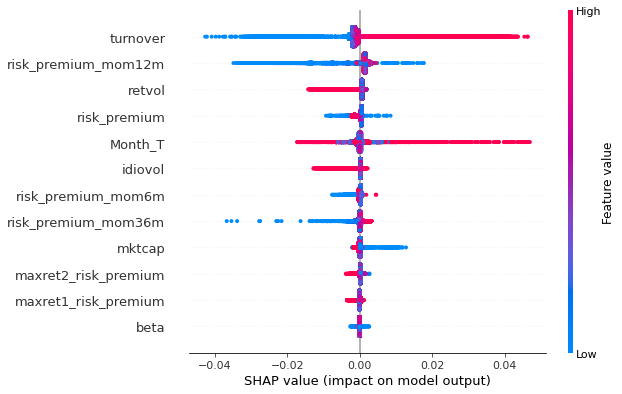

In [73]:
# 1 cross sectionally
rf = RandomForestRegressor(max_depth=3,random_state=0).fit(X_train1, Y_train1)
print(rf.score(X_test1,Y_test1)) 

# Shap for random forest
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train1)
shap.summary_plot(shap_values, X_train1)

-0.00022158038193942353


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


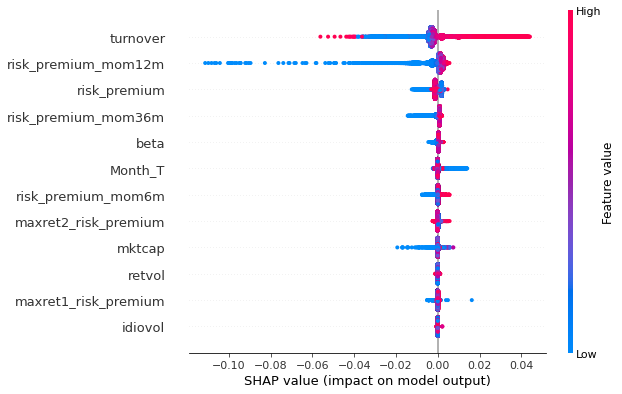

In [62]:
# 2 cross sectionally + sector
rf = RandomForestRegressor(max_depth=3,random_state=0).fit(X_train2, Y_train2)
print(rf.score(X_test2,Y_test2)) 

# Shap for random forest
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train2)
shap.summary_plot(shap_values, X_train2)